# Data Assimilation - Campo Grande

This notebook uses pre-fitted parameters to compare model predictions with observed data from `dataNew.csv`.

We will:
1. Load the fitted parameters for each terrain type (park, house, street)
2. Compute model predictions using these parameters
3. Compare predictions with observed data for each terrain type
4. Combine terrain predictions to compare with neighborhood-level data

In [20]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import readHistData as hist
from scipy.stats import pearsonr

# Set plot style
plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
    'lines.linewidth': 2.5,
    'axes.linewidth': 1.5
})

## 1. Load Data and Parameters

In [21]:
# Load the observed data
data = pd.read_csv('dataNew.csv')
print("Observed data:")
data.head(10)

Observed data:


,Day,OVT_house,OVT_park,OVT_street,ADT_house,ADT_park,ADT_street,Temperature,Pluviosity
0,0,44.000305,303.115848,0.000000,3.210498,120.338918,0.000000,22.264035,74.075
1,30,42.787514,343.946257,0.000000,0.000000,0.000000,43.760058,21.515932,44.250
2,60,0.000000,196.465911,225.074052,0.000000,61.872981,13.872339,21.617614,56.825
3,90,0.000000,426.223380,97.933288,0.000000,1.659922,24.900416,21.994655,29.350
4,120,0.000000,87.520699,189.682171,0.000000,0.000000,26.830769,20.112675,15.500
5,150,15.244050,0.000000,0.000000,2.465426,0.000000,0.000000,16.995573,7.400
6,180,0.000000,0.000000,95.234710,0.000000,0.000000,12.029353,14.627970,9.500
7,210,0.000000,120.695241,83.889636,0.000000,0.000000,3.729814,17.369467,0.000
8,240,1.547962,152.268170,0.000000,0.144619,0.547091,0.000000,12.626904,2.425
9,270,12.611726,240.857569,0.000000,1.785750,0.000000,0.000000,21.784700,5.025


In [22]:
# Load fitted parameters (copied from Santarem results)
with open('results_new_params.json', 'r') as f:
    fitted_params = json.load(f)

print("Fitted parameters description:", fitted_params['description'])
print("\nPark parameters:")
for k, v in fitted_params['park'].items():
    print(f"  {k}: {v:.4f}")

Fitted parameters description: Results using new parametrization with TMIN=0, TMAX=40 and fractions

Park parameters:
  Tminmu1: 20.0000
  fraction_mu1: 0.5000
  Tmaxmu1: 30.0000
  Tmin2: 20.0000
  fraction_2: 0.5000
  Tmax2: 30.0000
  Tmin3: 25.0000
  fraction_3: 0.5000
  Tmax3: 32.5000
  Tmingamma: 29.8752
  fraction_gamma: 1.0000
  Tmaxgamma: 40.0000
  Tminr: 4.9597
  fraction_r: 0.9968
  Tmaxr: 39.8874
  Tmink: 30.1493
  fraction_k: 0.1046
  Tmaxk: 31.1794
  Tminee: 14.2500
  fraction_e: 0.5000
  Tmaxe: 27.1250


In [23]:
# Extract days and observed values
days = data['Day'].values

# Observed values for each terrain type
obs_park_ovt = data['OVT_park'].values
obs_park_adt = data['ADT_park'].values
obs_house_ovt = data['OVT_house'].values
obs_house_adt = data['ADT_house'].values
obs_street_ovt = data['OVT_street'].values
obs_street_adt = data['ADT_street'].values

print(f"Number of time points: {len(days)}")
print(f"Days range: {days[0]} to {days[-1]}")

Number of time points: 26
Days range: 0 to 750


## 2. Define Model Function

In [24]:
def compute_equilibria(params, days):
    """
    Compute OVT and ADT equilibrium values using the fitted parameters.
    
    Parameters:
    -----------
    params : dict
        Dictionary with fitted parameter values
    days : array-like
        Days to compute equilibria for
    
    Returns:
    --------
    ovt_values, adt_values : arrays
        Predicted OVT and ADT values
    """
    # Extract parameters
    Tminmu1 = params["Tminmu1"]
    Tmaxmu1 = params["Tmaxmu1"]
    Tmin2 = params["Tmin2"]
    Tmax2 = params["Tmax2"]
    Tmin3 = params["Tmin3"]
    Tmax3 = params["Tmax3"]
    Tmingamma = params["Tmingamma"]
    Tmaxgamma = params["Tmaxgamma"]
    Tminr = params["Tminr"]
    Tmaxr = params["Tmaxr"]
    Tmink = params["Tmink"]
    Tmaxk = params["Tmaxk"]
    Tminee = params["Tminee"]
    Tmaxe = params["Tmaxe"]
    
    # Base parameter values
    mu10 = 0.1170
    mu20 = 0.025
    mu30 = 0.01
    gamma0 = 0.5596
    r0 = 34
    k0 = 89000
    e0 = 0.24
    
    ovt_values = []
    adt_values = []
    
    for t in days:
        T = hist.temperature(t)
        P = hist.pluviosity(t)
        
        # Convert Tmin and Tmax to M (mean) and D (deviation) for each parameter
        Mmu1 = (Tminmu1 + Tmaxmu1) / 2
        Dmu1 = abs((Tmaxmu1 - Tminmu1)) / 2
        Mmu2 = (Tmin2 + Tmax2) / 2
        Dmu2 = abs((Tmax2 - Tmin2)) / 2
        Mmu3 = (Tmin3 + Tmax3) / 2
        Dmu3 = abs((Tmax3 - Tmin3)) / 2
        Mgamma = (Tmingamma + Tmaxgamma) / 2
        Dgamma = abs((Tmaxgamma - Tmingamma)) / 2
        Mr = (Tminr + Tmaxr) / 2
        Dr = abs((Tmaxr - Tminr)) / 2
        Mk = (Tmink + Tmaxk) / 2
        Dk = abs((Tmaxk - Tmink)) / 2
        Me = (Tminee + Tmaxe) / 2
        De = abs((Tmaxe - Tminee)) / 2
        
        # Compute temperature-dependent parameters
        mu1 = (2 - hist.plateau(Dmu1, Mmu1, T)) * mu10
        mu2 = (2 - hist.plateau(Dmu2, Mmu2, T)) * mu20
        mu3 = (2 - hist.plateau(Dmu3, Mmu3, T)) * mu30
        gamma = hist.normal(Dgamma, Mgamma, T) * gamma0
        r = hist.phi(P) * hist.normal(Dr, Mr, T) * r0
        k = hist.phi(P) * hist.normal(Dk, Mk, T) * k0
        e = e0 * hist.normal(De, Me, T) * hist.phi(P)
        
        # Compute Q0 (basic reproduction number)
        denominator_q0 = mu1 * (mu2 + gamma) * (mu3 + e)
        if denominator_q0 == 0:
            Q0 = 0
        else:
            Q0 = (gamma * e * r) / denominator_q0
        
        # Compute equilibria
        if Q0 > 1:
            eqADT = k * (gamma / mu1) * (1 - 1 / Q0)
            denominator_eqOVT = mu1 * (mu3 + e)
            if denominator_eqOVT == 0:
                eqOVT = 0
            else:
                eqOVT = k * (gamma * r) / denominator_eqOVT * (1 - 1 / Q0)
        else:
            eqADT = 0
            eqOVT = 0
        
        ovt_values.append(eqOVT)
        adt_values.append(eqADT)
    
    return np.array(ovt_values), np.array(adt_values)

## 3. Compute Predictions for Each Terrain Type

In [25]:
# Compute predictions for each terrain type
pred_park_ovt, pred_park_adt = compute_equilibria(fitted_params['park'], days)
pred_house_ovt, pred_house_adt = compute_equilibria(fitted_params['house'], days)
pred_street_ovt, pred_street_adt = compute_equilibria(fitted_params['street'], days)

print("Predictions computed for all terrain types.")

Predictions computed for all terrain types.


## 4. Compare Predictions with Observed Data by Terrain Type

In [26]:
def plot_comparison(days, observed, predicted, title, ylabel):
    """Plot observed vs predicted values with double y-axis."""
    fig, ax1 = plt.subplots(figsize=(12, 5))

    # Left y-axis for observed data
    color_obs = 'crimson'
    ax1.set_xlabel('Days')
    ax1.set_ylabel(f'{ylabel} (Observed)', color=color_obs)
    line1 = ax1.plot(days, observed, 'o-', label='Observed', color=color_obs, markersize=6)
    ax1.tick_params(axis='y', labelcolor=color_obs)
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Right y-axis for predicted data
    ax2 = ax1.twinx()
    color_pred = 'royalblue'
    ax2.set_ylabel(f'{ylabel} (Predicted)', color=color_pred)
    line2 = ax2.plot(days, predicted, 's--', label='Predicted', color=color_pred, markersize=6)
    ax2.tick_params(axis='y', labelcolor=color_pred)

    # Combined legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')

    ax1.set_title(title)

    # Compute correlation
    corr, pval = pearsonr(observed, predicted)
    ax1.text(0.02, 0.98, f'Pearson r = {corr:.3f}', transform=ax1.transAxes,
            verticalalignment='top', fontsize=14,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    return corr

### 4.1 Park

/var/folders/_c/wqlz16pj5530wg9sb_zqc_lr0000gp/T/ipykernel_11480/2050231605.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = pearsonr(observed, predicted)


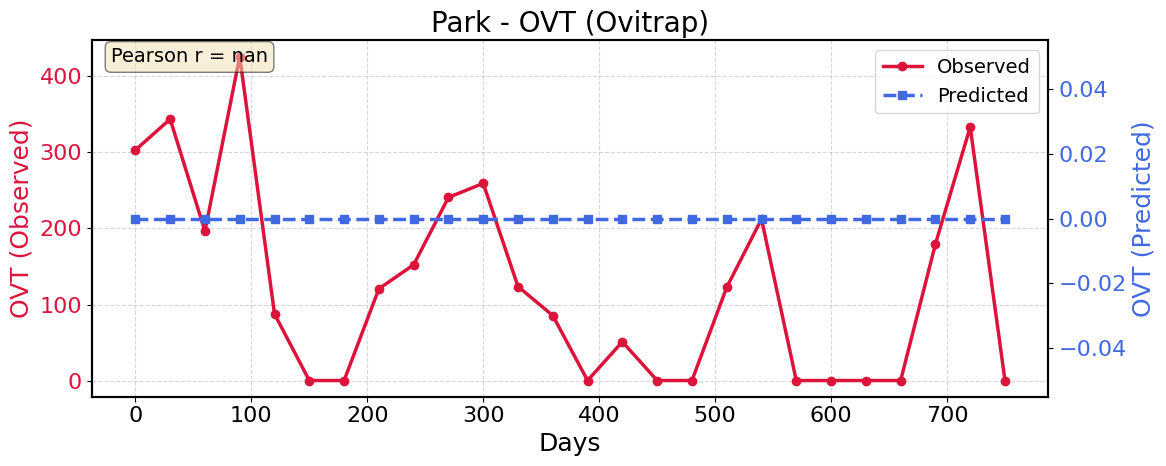

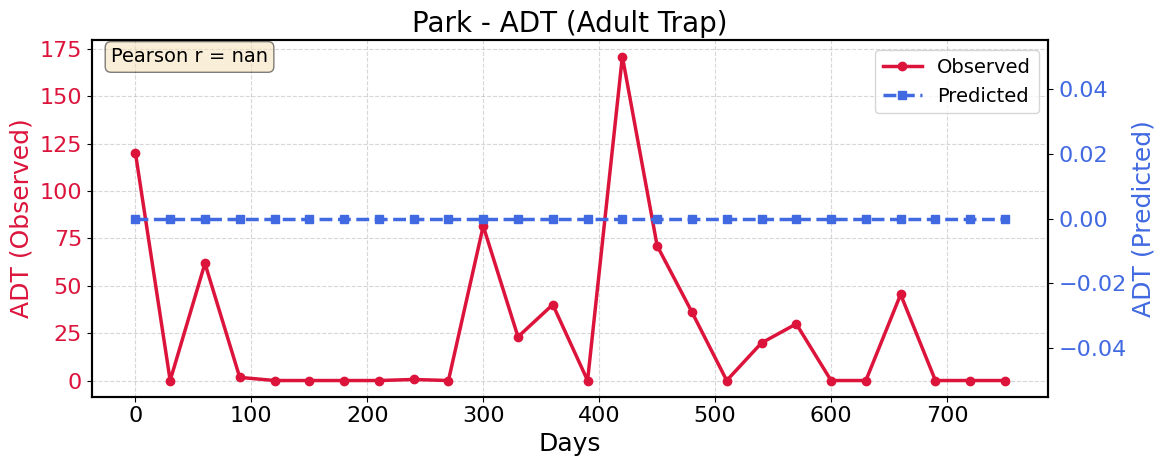

In [27]:
corr_park_ovt = plot_comparison(days, obs_park_ovt, pred_park_ovt, 'Park - OVT (Ovitrap)', 'OVT')
plt.show()

corr_park_adt = plot_comparison(days, obs_park_adt, pred_park_adt, 'Park - ADT (Adult Trap)', 'ADT')
plt.show()

### 4.2 House

/var/folders/_c/wqlz16pj5530wg9sb_zqc_lr0000gp/T/ipykernel_11480/2050231605.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = pearsonr(observed, predicted)


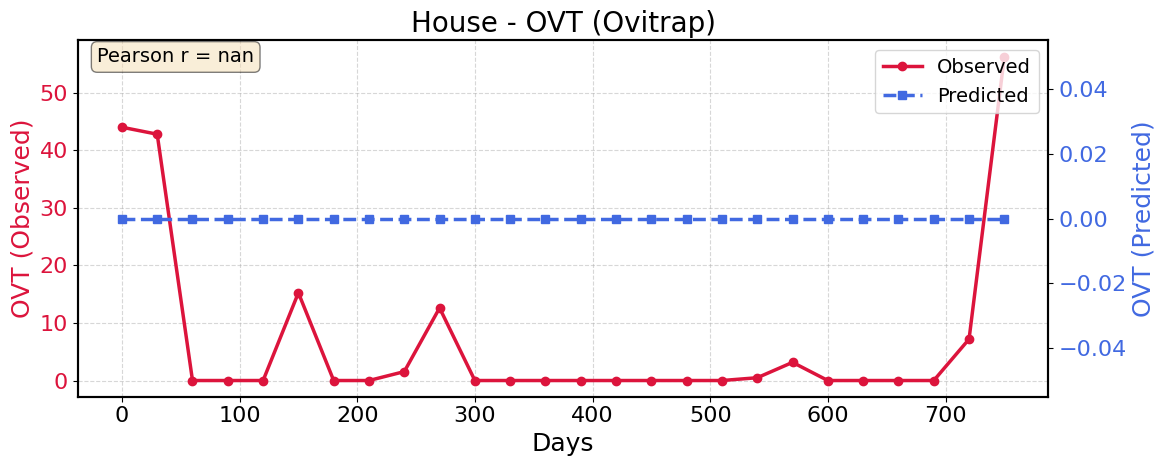

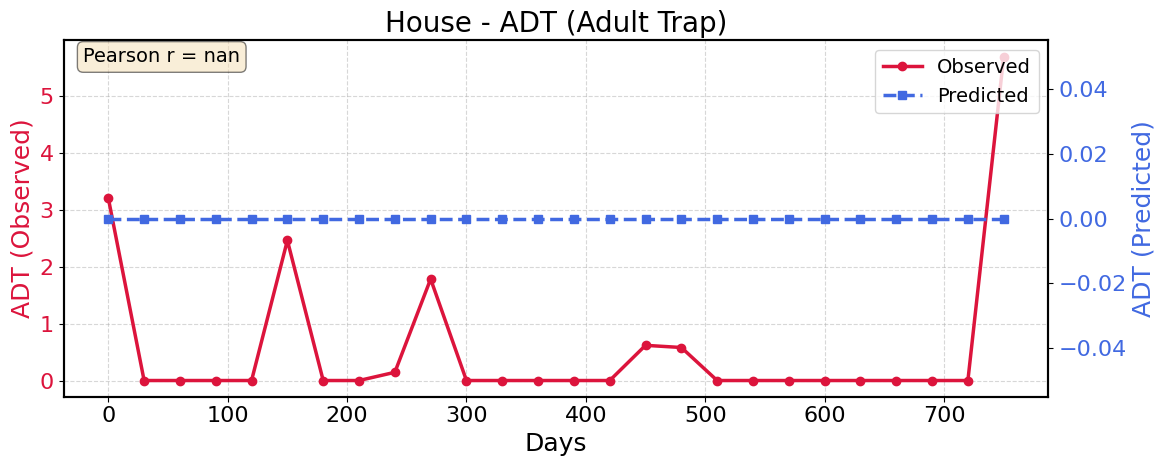

In [28]:
corr_house_ovt = plot_comparison(days, obs_house_ovt, pred_house_ovt, 'House - OVT (Ovitrap)', 'OVT')
plt.show()

corr_house_adt = plot_comparison(days, obs_house_adt, pred_house_adt, 'House - ADT (Adult Trap)', 'ADT')
plt.show()

### 4.3 Street

/var/folders/_c/wqlz16pj5530wg9sb_zqc_lr0000gp/T/ipykernel_11480/2050231605.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = pearsonr(observed, predicted)


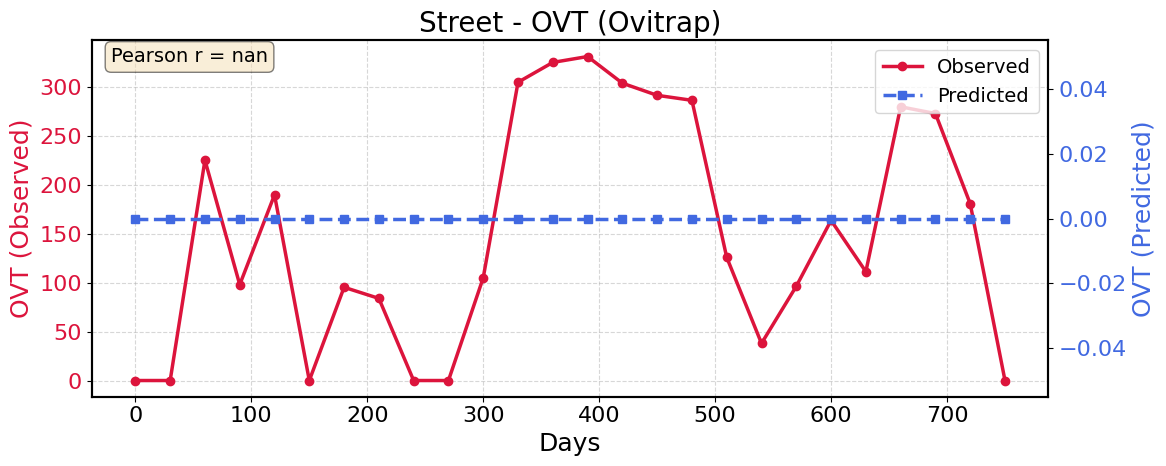

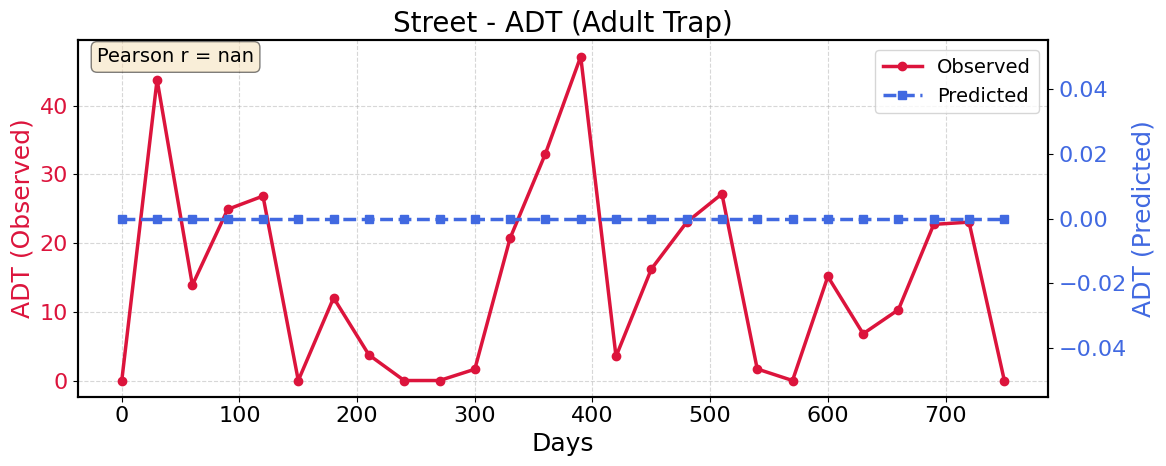

In [29]:
corr_street_ovt = plot_comparison(days, obs_street_ovt, pred_street_ovt, 'Street - OVT (Ovitrap)', 'OVT')
plt.show()

corr_street_adt = plot_comparison(days, obs_street_adt, pred_street_adt, 'Street - ADT (Adult Trap)', 'ADT')
plt.show()

### 4.4 Summary of Correlations by Terrain Type

In [30]:
print("=" * 50)
print("Pearson Correlations by Terrain Type")
print("=" * 50)
print(f"\n{'Terrain':<10} {'OVT':>10} {'ADT':>10}")
print("-" * 30)
print(f"{'Park':<10} {corr_park_ovt:>10.3f} {corr_park_adt:>10.3f}")
print(f"{'House':<10} {corr_house_ovt:>10.3f} {corr_house_adt:>10.3f}")
print(f"{'Street':<10} {corr_street_ovt:>10.3f} {corr_street_adt:>10.3f}")

Pearson Correlations by Terrain Type

Terrain           OVT        ADT
------------------------------
Park              nan        nan
House             nan        nan
Street            nan        nan


## 5. Combined Analysis - Neighborhood Level

Now we combine the terrain predictions using the proportion matrix to compare with neighborhood-level observations.

In [31]:
# Load original CSV to get proportion matrix
# (These will be calculated in dataPreparation.ipynb and loaded here)
# For now, we use approximate values based on typical urban areas

# Load observed neighborhood data from original CSV
df_orig = pd.read_csv('../data/CampoGrande.csv')

# Handle missing values
CarlotaOVT = df_orig['OVT_Carlota'].ffill().bfill().values
GuanandiOVT = df_orig['OVT_Guanandi'].ffill().bfill().values
PlanaltoOVT = df_orig['OVT_Planalto'].ffill().bfill().values

CarlotaADT = df_orig['ADT_Carlota'].ffill().bfill().values
GuanandiADT = df_orig['ADT_Guanandi'].ffill().bfill().values
PlanaltoADT = df_orig['ADT_Planalto'].ffill().bfill().values

print(f"Loaded observed data for {len(CarlotaOVT)} time points.")

Loaded observed data for 26 time points.


In [32]:
# Proportions computed from terrain analysis in dataPreparation.ipynb
# Format: [water, parks, streets, houses]
matProporcoes = np.array([
    [0.0000, 0.0452, 0.1486, 0.8063],  # Carlota
    [0.0000, 0.0147, 0.1581, 0.8272],  # Guanandi
    [0.0000, 0.0702, 0.1557, 0.7741],  # Planalto
])

print("Proportion matrix (neighborhoods x terrains):")
print("               Water    Park     Street    House")
for i, name in enumerate(['Carlota', 'Guanandi', 'Planalto']):
    print(f"{name:<12} {matProporcoes[i,0]:.4f}   {matProporcoes[i,1]:.4f}   {matProporcoes[i,2]:.4f}   {matProporcoes[i,3]:.4f}")

Proportion matrix (neighborhoods x terrains):
               Water    Park     Street    House
Carlota      0.0000   0.0452   0.1486   0.8063
Guanandi     0.0000   0.0147   0.1581   0.8272
Planalto     0.0000   0.0702   0.1557   0.7741


In [33]:
# Combine terrain predictions using proportion matrix
# Note: proportion order is [water, parks, streets, houses]
n_times = len(days)

pred_carlota_ovt = np.zeros(n_times)
pred_guanandi_ovt = np.zeros(n_times)
pred_planalto_ovt = np.zeros(n_times)

pred_carlota_adt = np.zeros(n_times)
pred_guanandi_adt = np.zeros(n_times)
pred_planalto_adt = np.zeros(n_times)

for t in range(n_times):
    # OVT predictions [water, park, street, house]
    terrain_ovt = [0, pred_park_ovt[t], pred_street_ovt[t], pred_house_ovt[t]]
    combined_ovt = matProporcoes @ terrain_ovt
    pred_carlota_ovt[t] = combined_ovt[0]
    pred_guanandi_ovt[t] = combined_ovt[1]
    pred_planalto_ovt[t] = combined_ovt[2]
    
    # ADT predictions
    terrain_adt = [0, pred_park_adt[t], pred_street_adt[t], pred_house_adt[t]]
    combined_adt = matProporcoes @ terrain_adt
    pred_carlota_adt[t] = combined_adt[0]
    pred_guanandi_adt[t] = combined_adt[1]
    pred_planalto_adt[t] = combined_adt[2]

print("Combined predictions computed for all neighborhoods.")

Combined predictions computed for all neighborhoods.


### 5.1 OVT Comparison at Neighborhood Level

/var/folders/_c/wqlz16pj5530wg9sb_zqc_lr0000gp/T/ipykernel_11480/2541940281.py:31: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(obs, pred)


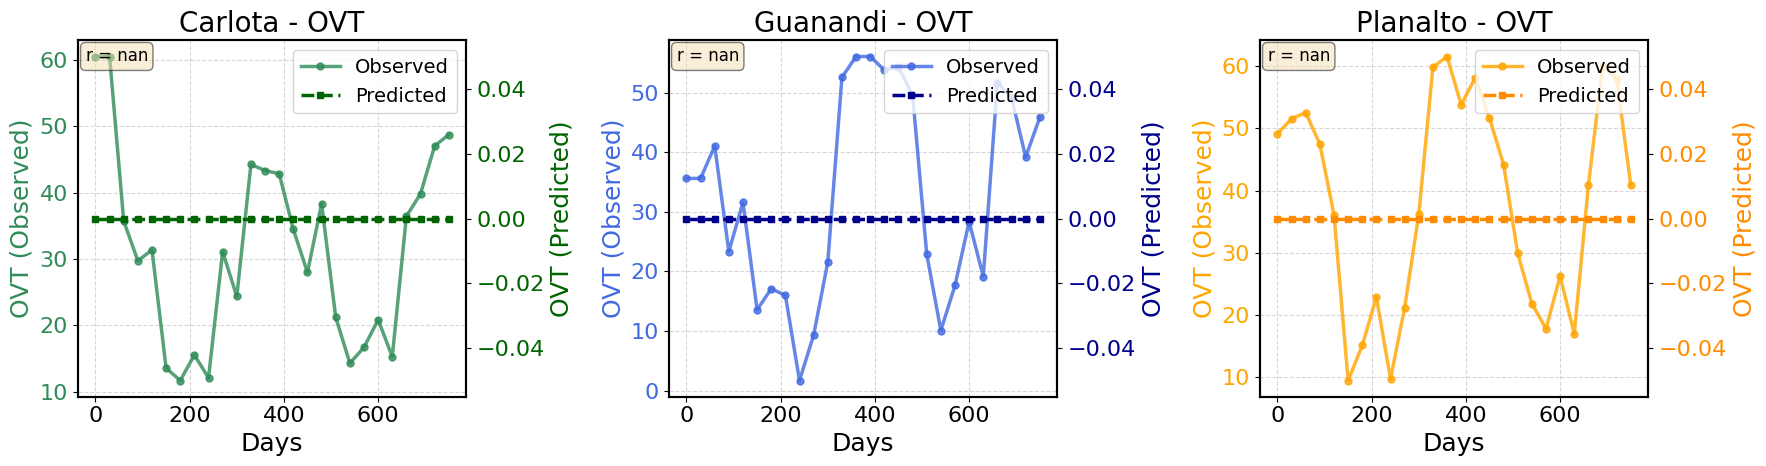

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

neighborhoods = ['Carlota', 'Guanandi', 'Planalto']
obs_ovt_list = [CarlotaOVT, GuanandiOVT, PlanaltoOVT]
pred_ovt_list = [pred_carlota_ovt, pred_guanandi_ovt, pred_planalto_ovt]
colors_obs = ['seagreen', 'royalblue', 'orange']
colors_pred = ['darkgreen', 'darkblue', 'darkorange']

corr_ovt = []
for ax1, name, obs, pred, color_obs, color_pred in zip(axes, neighborhoods, obs_ovt_list, pred_ovt_list, colors_obs, colors_pred):
    # Left y-axis for observed
    ax1.set_xlabel('Days')
    ax1.set_ylabel('OVT (Observed)', color=color_obs)
    line1 = ax1.plot(days, obs, 'o-', label='Observed', color=color_obs, alpha=0.8, markersize=5)
    ax1.tick_params(axis='y', labelcolor=color_obs)
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    # Right y-axis for predicted
    ax2 = ax1.twinx()
    ax2.set_ylabel('OVT (Predicted)', color=color_pred)
    line2 = ax2.plot(days, pred, 's--', label='Predicted', color=color_pred, markersize=5)
    ax2.tick_params(axis='y', labelcolor=color_pred)
    
    # Combined legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')
    
    ax1.set_title(f'{name} - OVT')
    
    corr, _ = pearsonr(obs, pred)
    corr_ovt.append(corr)
    ax1.text(0.02, 0.98, f'r = {corr:.3f}', transform=ax1.transAxes,
            verticalalignment='top', fontsize=12,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

### 5.2 ADT Comparison at Neighborhood Level

/var/folders/_c/wqlz16pj5530wg9sb_zqc_lr0000gp/T/ipykernel_11480/2982894165.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(obs, pred)


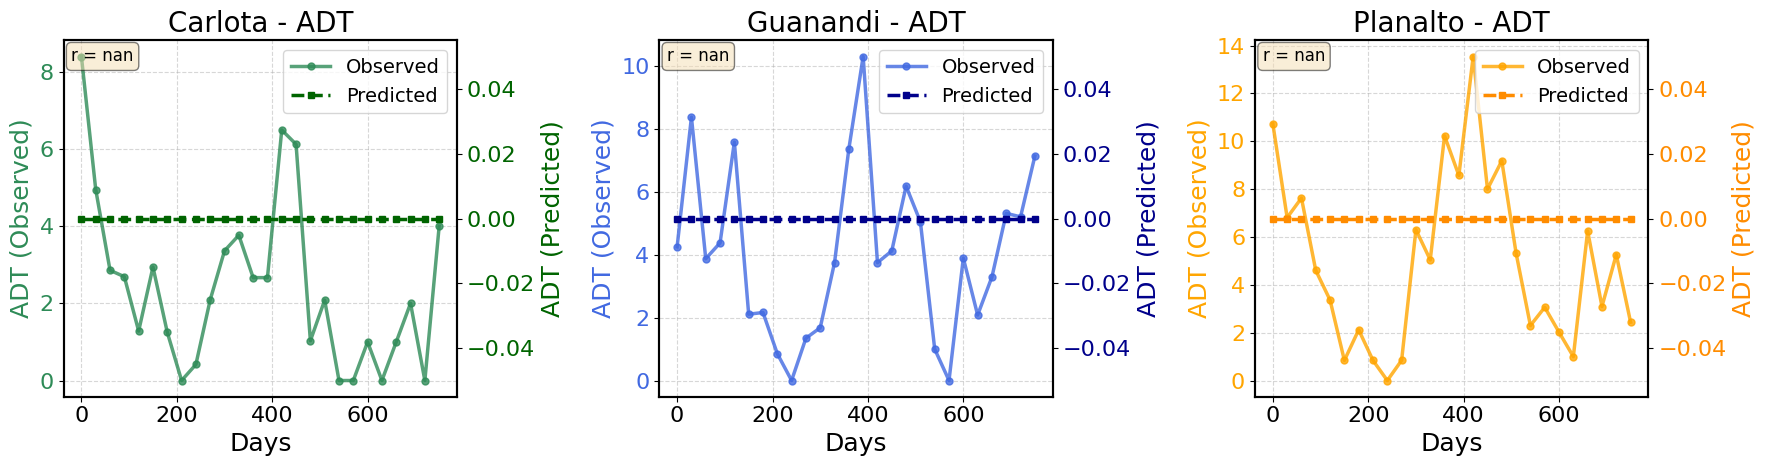

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

obs_adt_list = [CarlotaADT, GuanandiADT, PlanaltoADT]
pred_adt_list = [pred_carlota_adt, pred_guanandi_adt, pred_planalto_adt]

corr_adt = []
for ax1, name, obs, pred, color_obs, color_pred in zip(axes, neighborhoods, obs_adt_list, pred_adt_list, colors_obs, colors_pred):
    # Left y-axis for observed
    ax1.set_xlabel('Days')
    ax1.set_ylabel('ADT (Observed)', color=color_obs)
    line1 = ax1.plot(days, obs, 'o-', label='Observed', color=color_obs, alpha=0.8, markersize=5)
    ax1.tick_params(axis='y', labelcolor=color_obs)
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    # Right y-axis for predicted
    ax2 = ax1.twinx()
    ax2.set_ylabel('ADT (Predicted)', color=color_pred)
    line2 = ax2.plot(days, pred, 's--', label='Predicted', color=color_pred, markersize=5)
    ax2.tick_params(axis='y', labelcolor=color_pred)
    
    # Combined legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')
    
    ax1.set_title(f'{name} - ADT')
    
    corr, _ = pearsonr(obs, pred)
    corr_adt.append(corr)
    ax1.text(0.02, 0.98, f'r = {corr:.3f}', transform=ax1.transAxes,
            verticalalignment='top', fontsize=12,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

### 5.3 Combined View - All Neighborhoods

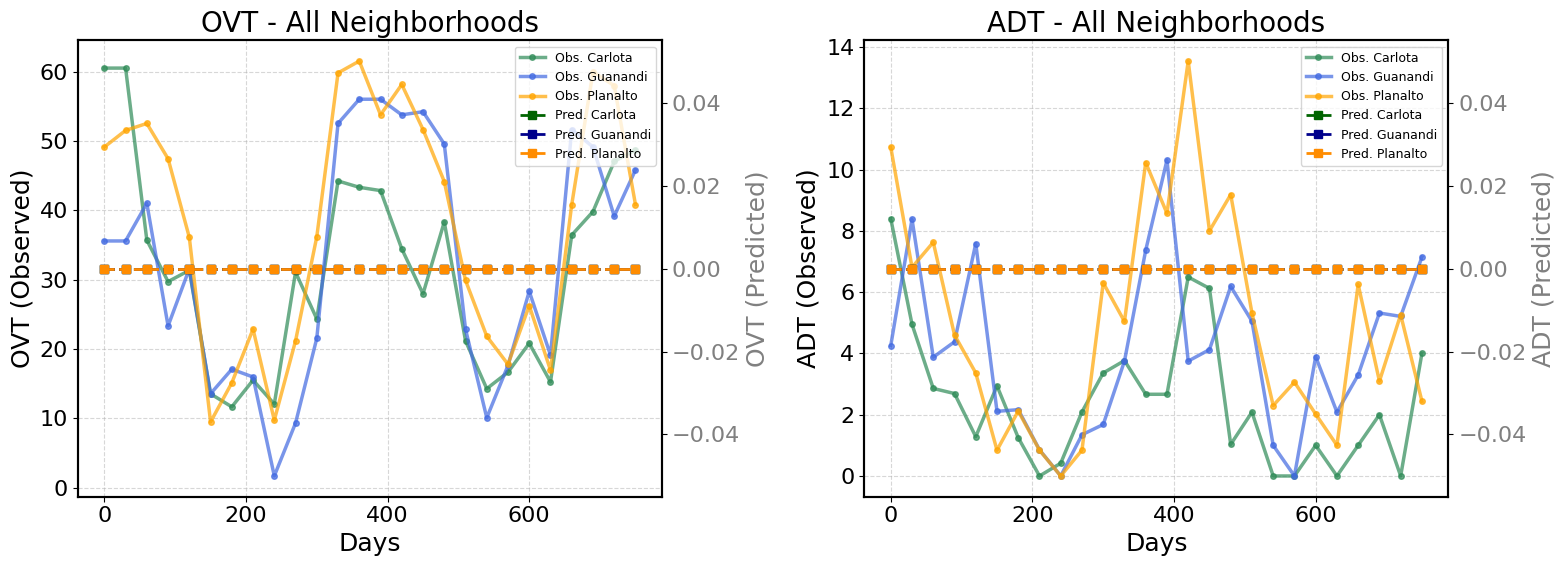

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# OVT with double y-axis
ax1 = axes[0]
# Left axis - Observed
ax1.set_xlabel('Days')
ax1.set_ylabel('OVT (Observed)', color='black')
l1 = ax1.plot(days, CarlotaOVT, 'o-', color='seagreen', alpha=0.7, markersize=4, label='Obs. Carlota')
l2 = ax1.plot(days, GuanandiOVT, 'o-', color='royalblue', alpha=0.7, markersize=4, label='Obs. Guanandi')
l3 = ax1.plot(days, PlanaltoOVT, 'o-', color='orange', alpha=0.7, markersize=4, label='Obs. Planalto')
ax1.tick_params(axis='y')
ax1.grid(True, linestyle='--', alpha=0.5)

# Right axis - Predicted
ax1b = ax1.twinx()
ax1b.set_ylabel('OVT (Predicted)', color='gray')
l4 = ax1b.plot(days, pred_carlota_ovt, 's--', color='darkgreen', linewidth=2, label='Pred. Carlota')
l5 = ax1b.plot(days, pred_guanandi_ovt, 's--', color='darkblue', linewidth=2, label='Pred. Guanandi')
l6 = ax1b.plot(days, pred_planalto_ovt, 's--', color='darkorange', linewidth=2, label='Pred. Planalto')
ax1b.tick_params(axis='y', labelcolor='gray')

lines = l1 + l2 + l3 + l4 + l5 + l6
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right', fontsize=9)
ax1.set_title('OVT - All Neighborhoods')

# ADT with double y-axis
ax2 = axes[1]
# Left axis - Observed
ax2.set_xlabel('Days')
ax2.set_ylabel('ADT (Observed)', color='black')
l1 = ax2.plot(days, CarlotaADT, 'o-', color='seagreen', alpha=0.7, markersize=4, label='Obs. Carlota')
l2 = ax2.plot(days, GuanandiADT, 'o-', color='royalblue', alpha=0.7, markersize=4, label='Obs. Guanandi')
l3 = ax2.plot(days, PlanaltoADT, 'o-', color='orange', alpha=0.7, markersize=4, label='Obs. Planalto')
ax2.tick_params(axis='y')
ax2.grid(True, linestyle='--', alpha=0.5)

# Right axis - Predicted
ax2b = ax2.twinx()
ax2b.set_ylabel('ADT (Predicted)', color='gray')
l4 = ax2b.plot(days, pred_carlota_adt, 's--', color='darkgreen', linewidth=2, label='Pred. Carlota')
l5 = ax2b.plot(days, pred_guanandi_adt, 's--', color='darkblue', linewidth=2, label='Pred. Guanandi')
l6 = ax2b.plot(days, pred_planalto_adt, 's--', color='darkorange', linewidth=2, label='Pred. Planalto')
ax2b.tick_params(axis='y', labelcolor='gray')

lines = l1 + l2 + l3 + l4 + l5 + l6
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='upper right', fontsize=9)
ax2.set_title('ADT - All Neighborhoods')

plt.tight_layout()
plt.show()

## 6. Summary Statistics

In [37]:
print("=" * 60)
print("SUMMARY: Pearson Correlations")
print("=" * 60)

print("\n--- By Terrain Type ---")
print(f"{'Terrain':<10} {'OVT':>10} {'ADT':>10}")
print("-" * 30)
print(f"{'Park':<10} {corr_park_ovt:>10.3f} {corr_park_adt:>10.3f}")
print(f"{'House':<10} {corr_house_ovt:>10.3f} {corr_house_adt:>10.3f}")
print(f"{'Street':<10} {corr_street_ovt:>10.3f} {corr_street_adt:>10.3f}")

print("\n--- By Neighborhood (Combined) ---")
print(f"{'Neighborhood':<14} {'OVT':>10} {'ADT':>10}")
print("-" * 34)
for name, c_ovt, c_adt in zip(neighborhoods, corr_ovt, corr_adt):
    print(f"{name:<14} {c_ovt:>10.3f} {c_adt:>10.3f}")

print("\n--- Overall Averages ---")
avg_terrain_ovt = np.mean([corr_park_ovt, corr_house_ovt, corr_street_ovt])
avg_terrain_adt = np.mean([corr_park_adt, corr_house_adt, corr_street_adt])
avg_neigh_ovt = np.mean(corr_ovt)
avg_neigh_adt = np.mean(corr_adt)

print(f"Avg. Terrain:     OVT = {avg_terrain_ovt:.3f}, ADT = {avg_terrain_adt:.3f}")
print(f"Avg. Neighborhood: OVT = {avg_neigh_ovt:.3f}, ADT = {avg_neigh_adt:.3f}")

SUMMARY: Pearson Correlations

--- By Terrain Type ---
Terrain           OVT        ADT
------------------------------
Park              nan        nan
House             nan        nan
Street            nan        nan

--- By Neighborhood (Combined) ---
Neighborhood          OVT        ADT
----------------------------------
Carlota               nan        nan
Guanandi              nan        nan
Planalto              nan        nan

--- Overall Averages ---
Avg. Terrain:     OVT = nan, ADT = nan
Avg. Neighborhood: OVT = nan, ADT = nan


## 7. Environmental Context

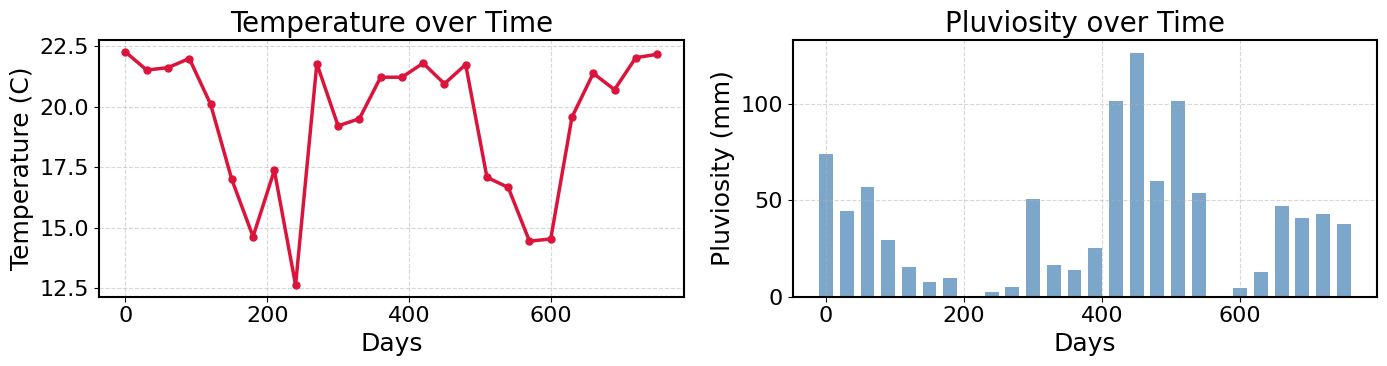

In [38]:
# Plot temperature and pluviosity
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

temperatures = [hist.temperature(t) for t in days]
pluviosities = [hist.pluviosity(t) for t in days]

ax = axes[0]
ax.plot(days, temperatures, 'o-', color='crimson', markersize=5)
ax.set_xlabel('Days')
ax.set_ylabel('Temperature (C)')
ax.set_title('Temperature over Time')
ax.grid(True, linestyle='--', alpha=0.5)

ax = axes[1]
ax.bar(days, pluviosities, width=20, color='steelblue', alpha=0.7)
ax.set_xlabel('Days')
ax.set_ylabel('Pluviosity (mm)')
ax.set_title('Pluviosity over Time')
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()